# Sprint 機械学習スクラッチ ロジスティック回帰

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。


g
(
z
)
=
1
1
+
e
−
z
.

線形回帰の仮定関数は次の式でした。


h
θ
(
x
)
=
θ
T
⋅
x
.

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。


h
θ
(
x
)
=
1
1
+
e
−
θ
T
⋅
x
.

$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

In [276]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose, save):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose

        # 保存有無
        self.save = save
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 訓練データ・学習データのインスタンス変数化
        self.X, self.y, self.X_val, self.y_val, self.theta = self._setting(X, y, X_val, y_val)       
        
        # 重み更新記録用配列
        self.update = np.zeros((self.iter, len(self.theta)))

        for i in range(self.iter):
            self.linear_hypo = self._linear_hypothesis(self.X)            
            self.grad = self._gradient_descent(self.X, self.y)
            self.update[i] = self.grad
            
            self.predict_prob = self.predict_proba(self.X)            
            self.loss[i] = self.loss_func(self.y)
            
            if X_val is not None and y_val is not None:
                self.val_predict_prob = self.predict_proba(self.X_val)
                self.val_loss[i] = self.val_loss_func(self.y_val)
            
            if self.verbose:
                # verboseをTrueにした際は学習過程を出力
                print("iter{}:[loss]:{}".format(i, self.loss[i]))
                print("iter{}:[val_loss]:{}".format(i, self.val_loss[i]))
        
        if self.save:
            np.save("./Update_theta", self.update)
            

    def _setting(self, X, y, X_val, y_val):       
        X_copy = np.copy(X)
        y_copy = np.copy(y)
        
        if X_val is not None and y_val is not None:
            X_val_copy = np.copy(X_val)
            y_val_copy = np.copy(y_val)
                
        if self.no_bias == False:
            X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            X_val_ones = np.ones(X_val.shape[0]).reshape(-1, 1)                
            X_copy = np.hstack((X_ones, X_copy))
            X_val_copy = np.hstack((X_val_ones, X_val_copy))
            np.random.seed(0)
            theta = np.random.randn(X.shape[1] + 1)
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

        else:
            np.random.seed(0)
            theta = np.random.randn(X.shape[1])
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """ 
        pred = self.predict_proba(X).round().astype(int)       
        return pred

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        pred_pro = self._linear_hypothesis(X)
        return pred_pro
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        g = np.dot(X, self.theta.T).reshape(-1, 1)
        hypo = 1/ (1 + np.exp(-g))

        return hypo

    def _gradient_descent(self, X, y, lamda=1, alpha=0.01, error=0):
        """
        最急降下法

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        alpha：学習率

        lamda：正則化パラメータ

        Returns
        -------

        """
        m = len(X)

        # バイアス項有
        if self.no_bias == False:
            grad = np.average(np.dot(X.T,(self.linear_hypo - y)))
            
            # 1列目以降のものをλ*theta/mで足す
            delta_theta = grad[:, 1:] + lamda*self.theta.reshape(-1,1) /(m-1)
            # 0列目と合わせる
            delta_theta = np.hstack([grad[:, 0].reshape(-1, 1), delta_theta])

        # バイアス項無
        else:
            grad = np.average(np.dot(X.T,(self.linear_hypo - y)))
            delta_theta = grad + lamda*self.theta.reshape(-1, 1)/m
        
        grad_average = np.average(delta_theta)
        self.theta = self.theta - alpha*grad_average

        return self.theta

    def loss_func(self, y, lamda=1):
        """
        損失関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
        訓練データまたはテストデータ

        Returns
        ----------
        """
        m = len(y)
        loss = np.average((-y*np.log(self.predict_prob)) - ((1-y)*np.log(1-self.predict_prob))) + lamda*(self.theta[1:]**2).sum() / 2*m
        
        return loss
    
    def val_loss_func(self, y, lamda=1):
        """
        損失関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
        テストデータ用

        Returns
        ----------
        """
        m = len(y)
        val_loss = np.average((-y*np.log(self.val_predict_prob)) - ((1-y)*np.log(1-self.val_predict_prob))) + lamda*(self.theta[1:]**2).sum() / 2*m
        return val_loss
        

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。


θ
j
:=
θ
j
−
α
∂
J
(
θ
)
∂
θ
j
<
b
r
/
>
∂
J
(
θ
)
∂
θ
0
=
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
,
j
=
0
<
b
r
/
>
∂
J
(
θ
)
∂
θ
j
=
(
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
)
+
λ
m
θ
j
　
,
j
≥
1

$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

In [208]:
scr_lr = ScratchLogisticRegression(num_iter=100, 
                                   lr=0.01,
                                   no_bias=True, 
                                   verbose=True)

scr_lr.fit(X_array, y_array, X_val, y_val)

iter0:[loss]:4.019800056117848
iter0:[val_loss]:2.6896619967016395
iter1:[loss]:3.914355267157075
iter1:[val_loss]:2.614671331439835
iter2:[loss]:3.8111418267628765
iter2:[val_loss]:2.5417971312301852
iter3:[loss]:3.7101494828627937
iter3:[val_loss]:2.471026712210036
iter4:[loss]:3.6113683063268796
iter4:[val_loss]:2.402347480798854
iter5:[loss]:3.514788712155221
iter5:[val_loss]:2.335746935368734
iter6:[loss]:3.4204014806301495
iter6:[val_loss]:2.2712126685795373
iter7:[loss]:3.328197782619376
iter7:[val_loss]:2.20873237033888
iter8:[loss]:3.2381692041881305
iter8:[val_loss]:2.1482938315872806
iter9:[loss]:3.1503077747983257
iter9:[val_loss]:2.0898849490861733
iter10:[loss]:3.064605996133409
iter10:[val_loss]:2.033493731778819
iter11:[loss]:2.981056874213982
iter11:[val_loss]:1.9791083089629757
iter12:[loss]:2.8996539529385847
iter12:[val_loss]:1.9267169409259348
iter13:[loss]:2.8203913506432734
iter13:[val_loss]:1.8763080326847834
iter14:[loss]:2.7432637992837168
iter14:[val_loss]:1.

In [209]:
scr_lr.predict_proba(X_val)

array([[0.98226456],
       [0.66617226],
       [0.97733871],
       [0.94391307],
       [0.28432818]])

In [210]:
scr_lr.predict(X_val)

array([[1],
       [1],
       [1],
       [1],
       [0]])

In [211]:
# sklearn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_array, y_array)
lr_pred = lr.predict(X_val)
lr_pred_proba = lr.predict_proba(X_val)

In [212]:
lr_pred_proba

array([[0.32945509, 0.67054491],
       [0.37662296, 0.62337704],
       [0.26119073, 0.73880927],
       [0.32050569, 0.67949431],
       [0.32750885, 0.67249115]])

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [48]:
from sklearn.datasets import load_iris

#データのダウンロードとXとY変数に代入
iris = load_iris()
df_X = pd.DataFrame(iris.data, columns=iris.feature_names)
df_X.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

df_Y = pd.DataFrame(iris.target)
df_Y.columns = ["Species"]

# データ結合 concat（axis=1）で列に配合
df_0 = pd.concat((df_X, df_Y), axis=1)

# virgicolorとvirginica sepal_lengthとpetal_lengthに再構築する
df = df_0.iloc[50:, :].reset_index()
df = df.drop("index", axis=1)
display(df.head())
display(df.tail())

# 前処理：目的変数【1,2】を【0,1】に置換する
df = df.replace({'Species': {1: 0}})
display(df.head())

df = df.replace({'Species': {2: 1}})
display(df.tail())

,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2
99,5.9,3.0,5.1,1.8,2


,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,0
1,6.4,3.2,4.5,1.5,0
2,6.9,3.1,4.9,1.5,0
3,5.5,2.3,4.0,1.3,0
4,6.5,2.8,4.6,1.5,0


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,1
96,6.3,2.5,5.0,1.9,1
97,6.5,3.0,5.2,2.0,1
98,6.2,3.4,5.4,2.3,1
99,5.9,3.0,5.1,1.8,1


In [213]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(75, 4)
(25, 4)


In [214]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)   #後でスケーリングするために使用する平均と標準を計算します。
X_train_scaler = scaler.transform(X_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X_test_scaler = scaler.transform(X_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [230]:
scr_lr_iris = ScratchLogisticRegression(num_iter=100, 
                                   lr=0.01,
                                   no_bias=False, 
                                   verbose=False)

scr_lr_iris.fit(X_train_scaler, y_train, X_test_scaler, y_test)

In [224]:
# sklearn
from sklearn.linear_model import LogisticRegression

lr_iris = LogisticRegression(random_state=0)
lr_iris.fit(X_train_scaler, y_train)
lr_iris_pred = lr_iris.predict(X_test_scaler)
lr_iris_pred_proba = lr_iris.predict_proba(X_test_scaler)

In [225]:
lr_iris_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1])

In [226]:
lr_iris_pred_proba[:, 1]

array([2.18194979e-01, 8.04490946e-01, 2.48684441e-01, 8.65580745e-01,
       8.26203796e-01, 6.07286517e-01, 1.12845892e-01, 8.81909022e-01,
       4.21220283e-01, 8.81886687e-04, 9.89693855e-01, 9.66146149e-01,
       9.59637795e-01, 1.48006673e-01, 1.55480629e-03, 9.56056448e-03,
       4.89220260e-01, 3.64417885e-02, 6.39110359e-01, 7.98814434e-02,
       1.86561193e-03, 9.54607114e-01, 4.53865351e-02, 7.09639662e-01,
       9.97142832e-01])

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

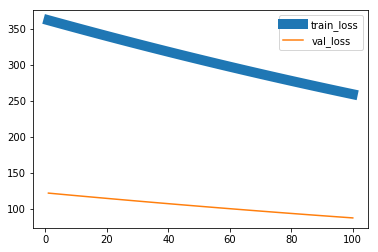

In [231]:
# 損失関数の描画
xlines = np.arange(1, len(scr_lr_iris.loss) + 1)

plt.plot(xlines, scr_lr_iris.loss, linewidth=10, label="train_loss")
plt.plot(xlines, scr_lr_iris.val_loss, label="val_loss")

plt.legend()
plt.show()

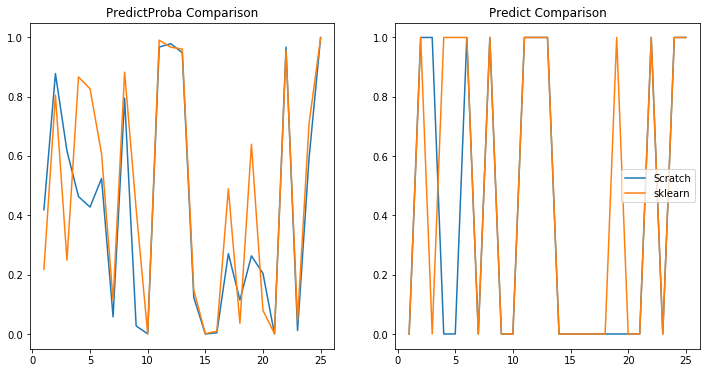

In [228]:
# probaの比較
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

xline = np.arange(1, len(lr_iris_pred_proba) + 1)

axes[0].set_title("PredictProba Comparison")
axes[0].plot(xline, scr_proba, label="Scratch")
axes[0].plot(xline, lr_iris_pred_proba[:, 1], label="sklearn")

axes[1].set_title("Predict Comparison")
axes[1].plot(xline, scr_predict, label="Scratch")
axes[1].plot(xline, lr_iris_pred, label="sklearn")

plt.legend()
plt.show()

## おおよそ同じ予測ができている。
- 違いは学習率やラムダの違いか？・・・

## 【問題7】決定領域の可視化
決定領域を可視化してください。

In [242]:
# 特徴量を2つに絞る。
X2 = df.iloc[:, :2].values
y2 = df.iloc[:, 4].values

X2_train, X2_test, y2_train, y2_test =  train_test_split(X2, y2, test_size=0.25, random_state=1)
print(X2_train.shape)
print(X2_test.shape)

(75, 2)
(25, 2)


In [243]:
scaler.fit(X2_train)   #後でスケーリングするために使用する平均と標準を計算します。
X2_train_scaler = scaler.transform(X2_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X2_test_scaler = scaler.transform(X2_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [233]:
scr_lr_iris2 = ScratchLogisticRegression(num_iter=500, 
                                   lr=0.01,
                                   no_bias=True, 
                                   verbose=False)

scr_lr_iris2.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [246]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスタンスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

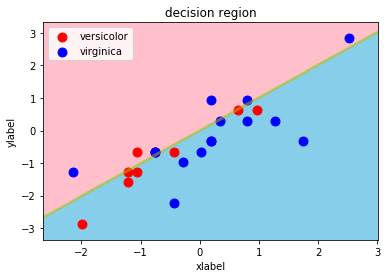

In [247]:
decision_region(X2_test_scaler, y2_test, scr_lr_iris2)

In [238]:
scr_lr2_proba = scr_lr_iris2.predict_proba(X2_test_scaler)
scr_lr2_predict = scr_lr_iris2.predict(X2_test_scaler)

In [239]:
scr_lr2_proba

array([[0.80427375],
       [0.6125786 ],
       [0.53418735],
       [0.44983729],
       [0.47886842],
       [0.48100123],
       [0.50590715],
       [0.58619287],
       [0.77038422],
       [0.37506079],
       [0.48100123],
       [0.50847012],
       [0.35317763],
       [0.66023082],
       [0.48100123],
       [0.48100123],
       [0.56182881],
       [0.42824223],
       [0.58619287],
       [0.63989667],
       [0.55888163],
       [0.61217293],
       [0.50633433],
       [0.58536351],
       [0.53503776]])

In [240]:
scr_lr2_predict

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

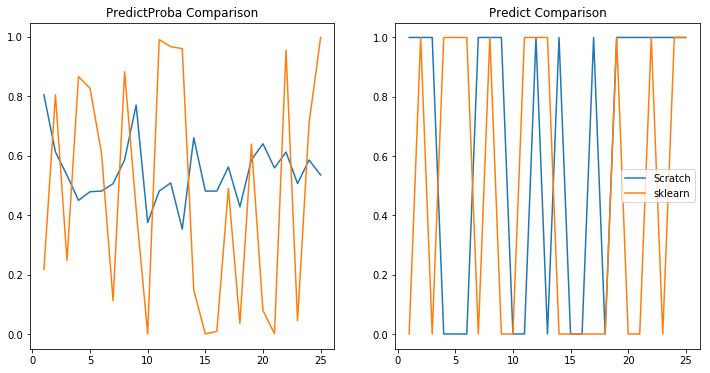

In [241]:
# probaの比較
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

xline = np.arange(1, len(lr_iris_pred_proba) + 1)

axes[0].set_title("PredictProba Comparison")
axes[0].plot(xline, scr_lr2_proba, label="Scratch")
axes[0].plot(xline, lr_iris_pred_proba[:, 1], label="sklearn")

axes[1].set_title("Predict Comparison")
axes[1].plot(xline, scr_lr2_predict, label="Scratch")
axes[1].plot(xline, lr_iris_pred, label="sklearn")

plt.legend()
plt.show()

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [279]:
# np.savezテスト用
scr_lr_iris3 = ScratchLogisticRegression(num_iter=30, 
                                   lr=0.01,
                                   no_bias=True, 
                                   verbose=False,
                                   save=True)

scr_lr_iris3.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [280]:
npz = np.load("./Update_theta.npy")

npz

array([[ 1.58462978,  0.22073464],
       [ 1.42177489,  0.05787976],
       [ 1.27760002, -0.08629512],
       [ 1.15353778, -0.21035736],
       [ 1.04996199, -0.31393315],
       [ 0.96597405, -0.39792109],
       [ 0.89953766, -0.46435748],
       [ 0.84794695, -0.51594819],
       [ 0.80837102, -0.55552412],
       [ 0.77823378, -0.58566135],
       [ 0.75537774, -0.6085174 ],
       [ 0.73808053, -0.62581461],
       [ 0.72500348, -0.63889166],
       [ 0.71512116, -0.64877398],
       [ 0.707654  , -0.65624114],
       [ 0.70201165, -0.66188349],
       [ 0.69774781, -0.66614732],
       [ 0.6945254 , -0.66936974],
       [ 0.69208981, -0.67180533],
       [ 0.69024877, -0.67364637],
       [ 0.68885706, -0.67503808],
       [ 0.68780494, -0.67609019],
       [ 0.68700953, -0.67688561],
       [ 0.68640816, -0.67748698],
       [ 0.68595349, -0.67794165],
       [ 0.68560972, -0.67828542],
       [ 0.6853498 , -0.67854534],
       [ 0.68515327, -0.67874187],
       [ 0.68500467,

## class内に組込し、更新されたthetaの保存と読み込みを確認できた。